In [2]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as MDA
from imblearn.over_sampling import SMOTE

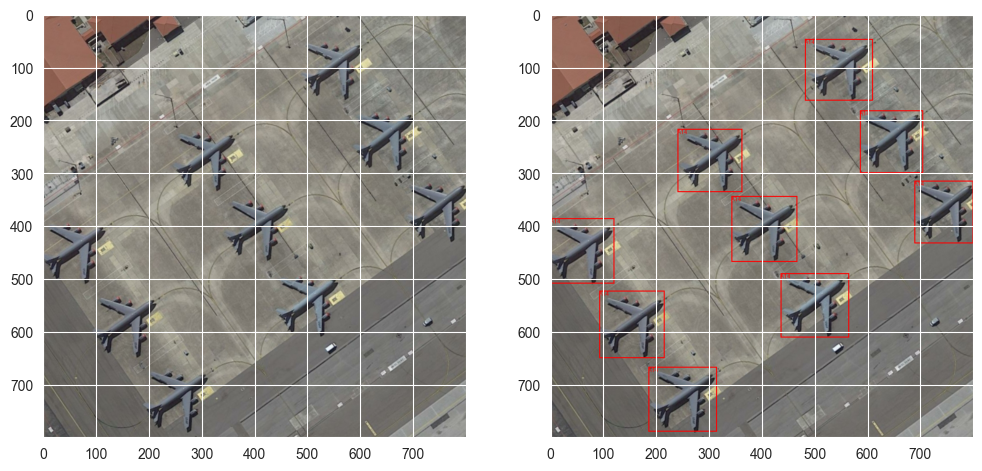

In [3]:
def read_annotations(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((label, (xmin, ymin, xmax, ymax)))
    return annotations

def load_image_and_annotations(filename):

    img_path = os.path.join(IMG_DIR, filename + '.jpg')
    xml_path = os.path.join(XML_DIR, filename + '.xml')
    image = Image.open(img_path)
    annotations = read_annotations(xml_path)
    return image, annotations

def draw_annotations(image, annotations):

    annotated = image.copy()
    draw = ImageDraw.Draw(annotated)
    for label, (xmin, ymin, xmax, ymax) in annotations:
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
        draw.text((xmin, ymin), label, fill='red')
    return annotated

DATA_DIR = '/Users/avilochab/Desktop/Grad_School/CSE 802/project/archive/'

IMG_DIR = os.path.join(DATA_DIR, 'JPEGImages')
XML_DIR = os.path.join(DATA_DIR, 'Annotations', 'Horizontal Bounding Boxes')
TRAIN_LIST_PATH = os.path.join(DATA_DIR, 'ImageSets', 'Main', 'train.txt')

with open(TRAIN_LIST_PATH, 'r') as f:
    train_filenames = f.read().splitlines()

sample_file = random.choice(train_filenames)

img, annots = load_image_and_annotations(sample_file)

img_annot = draw_annotations(img, annots)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_annot)


In [5]:
def extract_objects(data, target_size=(128, 128)):
    X = []
    y = []

    for filename in data:
        img, annots = load_image_and_annotations(filename)

        for label, (xmin, ymin, xmax, ymax) in annots:
            cropped = img.crop((xmin, ymin, xmax, ymax)).convert('RGB')  # Ensures 3 channels
            resized = cropped.resize(target_size)
            X.append(np.array(resized))
            y.append(label)

    X = np.array(X, dtype=np.uint8)  # Force uniform shape and data type
    y = np.array(y)
    return X, y

def extract_hog_features(X, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    features = []
    for img in X:
        gray = rgb2gray(img)
        hog_vec = hog(
            gray,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            feature_vector=True
        )
        features.append(hog_vec)
    return np.array(features)

def prepare_dataset(X, y, test_size=0.2):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42
    )
    return X_train, X_test, y_train, y_test, le


X_raw, y_raw = extract_objects(train_filenames)
X_hog = extract_hog_features(X_raw)


In [13]:
def evaluate_kernels_over_runs(X, y, kernels=['linear', 'rbf', 'poly', 'sigmoid'], runs=5):
    results = {k: [] for k in kernels}
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    for i in range(runs):
        print(f"\n--- Run {i+1} ---")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=i*42
        )

        for kernel in kernels:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svm', SVC(kernel=kernel, C=10, gamma='scale', degree=3))  # degree is relevant for 'poly'
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results[kernel].append(acc)
            print(f"{kernel} kernel accuracy: {acc:.4f}")

    print("\n=== Summary ===")
    for kernel in kernels:
        accs = results[kernel]
        print(f"{kernel} kernel -> Mean Accuracy: {np.mean(accs):.4f}, Std Dev: {np.std(accs):.4f}")

evaluate_kernels_over_runs(X_hog, y_raw)


--- Run 1 ---
linear kernel accuracy: 0.8177
rbf kernel accuracy: 0.8482
poly kernel accuracy: 0.6722
sigmoid kernel accuracy: 0.7630

--- Run 2 ---
linear kernel accuracy: 0.8183
rbf kernel accuracy: 0.8571
poly kernel accuracy: 0.6709
sigmoid kernel accuracy: 0.7440

--- Run 3 ---
linear kernel accuracy: 0.8310
rbf kernel accuracy: 0.8653
poly kernel accuracy: 0.6881
sigmoid kernel accuracy: 0.7694

--- Run 4 ---
linear kernel accuracy: 0.8177
rbf kernel accuracy: 0.8532
poly kernel accuracy: 0.6684
sigmoid kernel accuracy: 0.7503

--- Run 5 ---
linear kernel accuracy: 0.8164
rbf kernel accuracy: 0.8634
poly kernel accuracy: 0.6779
sigmoid kernel accuracy: 0.7484

=== Summary ===
linear kernel -> Mean Accuracy: 0.8202, Std Dev: 0.0054
rbf kernel -> Mean Accuracy: 0.8574, Std Dev: 0.0063
poly kernel -> Mean Accuracy: 0.6755, Std Dev: 0.0070
sigmoid kernel -> Mean Accuracy: 0.7550, Std Dev: 0.0096


In [8]:
#PCA

def evaluate_rbf_with_pca(X, y, n_components=100, runs=3):
    accuracies = []
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    for i in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=i*42
        )

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components)),
            ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"[PCA-RBF] Run {i+1} Accuracy: {acc:.4f}")

    print("\n📊 PCA + RBF Kernel Summary:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")


evaluate_rbf_with_pca(X_hog, y_raw, n_components=100)


[PCA-RBF] Run 1 Accuracy: 0.9231
[PCA-RBF] Run 2 Accuracy: 0.9136
[PCA-RBF] Run 3 Accuracy: 0.9282

📊 PCA + RBF Kernel Summary:
Mean Accuracy: 0.9216
Standard Deviation: 0.0061


In [9]:
#MDA

def evaluate_rbf_with_mda(X, y, runs=3):
    accuracies = []
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    for i in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=i*42
        )

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mda', MDA(n_components=None)),
            ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"[MDA-RBF] Run {i+1} Accuracy: {acc:.4f}")

    print("\n📊 MDA + RBF Kernel Summary:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")

evaluate_rbf_with_mda(X_hog, y_raw)


[MDA-RBF] Run 1 Accuracy: 0.5521
[MDA-RBF] Run 2 Accuracy: 0.5756
[MDA-RBF] Run 3 Accuracy: 0.5604

📊 MDA + RBF Kernel Summary:
Mean Accuracy: 0.5627
Standard Deviation: 0.0097


In [11]:
#SMOTE with PCA

def evaluate_rbf_with_pca_smote(X, y, n_components=100, runs=3):
    accuracies = []
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    for i in range(runs):
        print(f"\n🎬 Run {i+1}")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=i*42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

        clf = SVC(kernel='rbf', C=10, gamma='scale')
        clf.fit(X_train_resampled, y_train_resampled)

        y_pred = clf.predict(X_test_pca)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"Accuracy: {acc:.4f}")

    print("\n📊 PCA + SMOTE + RBF Kernel Summary:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")

evaluate_rbf_with_pca_smote(X_hog, y_raw, n_components=100)



🎬 Run 1
Accuracy: 0.9238

🎬 Run 2
Accuracy: 0.9142

🎬 Run 3
Accuracy: 0.9295

📊 PCA + SMOTE + RBF Kernel Summary:
Mean Accuracy: 0.9225
Standard Deviation: 0.0063
